### Introduction
Business objective: Prediction the buying price of a car given :
- Maintenance
- Number of doors
- Lug Boot Size
- Safety
- Class Value

Assumptions:
- `Higher comfort` - luggage boot size, number of doors & people, safety; `higher pricing` (positive correlation)
- `Higher class`; `higher pricing` (positive correlation)

### Table content
1. [Loading the data](#cell1)
2. [Discoverng and visualizing the data to gain insights](#cell2)
3. [Preparing the data for machine learning algorithms](#cell3)
4. [Training, evaluating and error analysis on the training set](#cell4)
    - [Logistic Regression](#cell41)
    - [Logistic Regression - Grid Search](#cell42)
    - [K-Nearest Neighbours](#cell43)
    - [Decision Trees](#cell44)
    - [Decision Trees - Grid Search](#cell45)
    - [Multi Layered Perceptron](#cell46)
    - [Multi Layered Perceptron - Grid Search](#cell47)
    - [Ensembling - Random Forest](#cell48)
5. [Selecting the best model](#cell5)
6. [Conclusions: Presenting solution](#cell6)

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Loading the data <a id="cell1"></a>

In [3]:
ATTRIBUTES = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [4]:
data = pd.read_csv("data/car.data", names=ATTRIBUTES)

## 2. Discoverng and visualizing the data to gain insights <a id="cell2"></a>

In [5]:
data.head(10)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


##### The attributes are Ordinal (Categorical)

In [6]:
for i in data.columns:
    print("{} attribute has {} values".format(i,data[i].unique()))

buying attribute has ['vhigh' 'high' 'med' 'low'] values
maint attribute has ['vhigh' 'high' 'med' 'low'] values
doors attribute has ['2' '3' '4' '5more'] values
persons attribute has ['2' '4' 'more'] values
lug_boot attribute has ['small' 'med' 'big'] values
safety attribute has ['low' 'med' 'high'] values
class attribute has ['unacc' 'acc' 'vgood' 'good'] values


##### The strata (subgroups ) are well-distributed (that's rare) except for the `class` attribute.

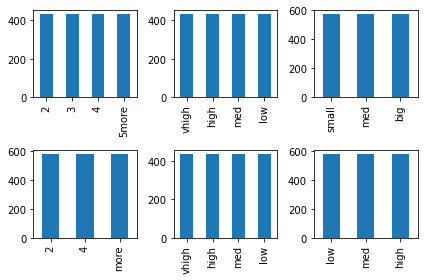

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3)

data['buying'].value_counts().plot(kind='bar', ax=axes[0,1])
data['maint'].value_counts().plot(kind='bar', ax=axes[1,1])
data['doors'].value_counts().plot(kind='bar', ax=axes[0,0])
data['persons'].value_counts().plot(kind='bar', ax=axes[1,0])
data['lug_boot'].value_counts().plot(kind='bar', ax=axes[0,2])
data['safety'].value_counts().plot(kind='bar', ax=axes[1,2])

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()

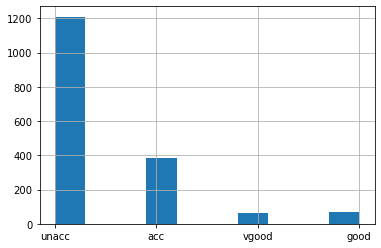

In [8]:
data['class'].hist()
plt.show()

In [9]:
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


##### Nice! There is no null value in the dataset.  

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


<AxesSubplot:>

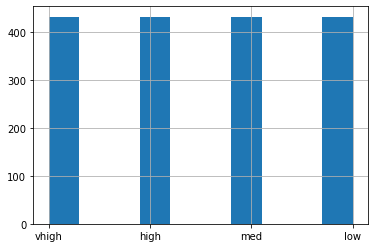

In [11]:
data['buying'].hist()

##### Negative correlation between `class` and `buying`

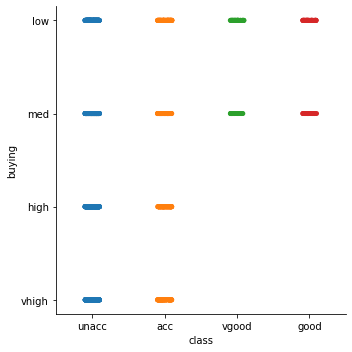

In [12]:
sns.catplot(x="class", y="buying", data=data)
plt.show()

Visualizing the distribution of `buying` across attributes 

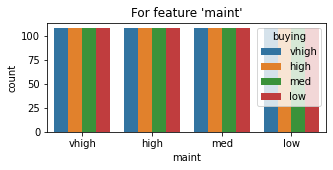

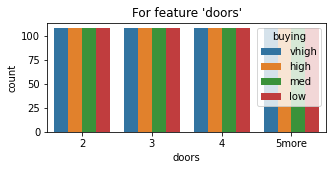

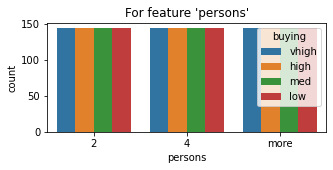

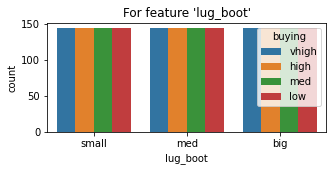

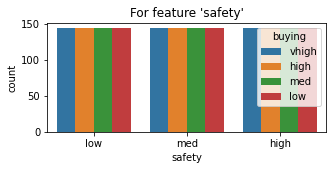

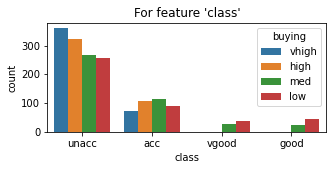

In [13]:
for i in data.columns[1:]:
    plt.figure(figsize=(5,2))
    plt.title("For feature '%s'"%i)
    sns.countplot(data[i],hue=data['buying'])

`vhigh` and `high` buying price are associated with only `unacc` and `acc` classes.

##### From the EDA on the data we observe that there is no need to handle missing values, feature scaling, outliers handling and so on. 

## 3. Preparing the data for Machine Learning Algorithms <a id="cell3"></a>

##### Performing ordinal encoding since they give better measure of the distance between different categories of an ordinal attribute


In [14]:
# ordinal mapping of the attributes
buying_mapping = {"vhigh": 3, "high": 2, "med": 1, 'low': 0}
maint_mapping = {"vhigh": 3, "high": 2, "med": 1, 'low': 0}
lug_boot_mapping = {"small": 0, "med": 1, "big": 2}
safety_mapping = {"low": 0, "med": 1, "high": 2}
class_mapping = {"unacc": 0, "acc": 1, "good": 2, "vgood": 3}
doors_mapping = {"2": 0, "3": 1, "4": 2, "5more": 3}
persons_mapping = {"2": 0, "3": 1, "more": 2}

In [15]:
# mapping the categories to the respective ordinal value for each attribute
trans_data = data.replace({"buying": buying_mapping})
trans_data = trans_data.replace({"maint": maint_mapping})
trans_data = trans_data.replace({"lug_boot": lug_boot_mapping})
trans_data = trans_data.replace({"safety": safety_mapping})
trans_data = trans_data.replace({"class": class_mapping})
trans_data = trans_data.replace({"persons": persons_mapping})
trans_data = trans_data.replace({"doors": doors_mapping})

##### Now we have the data in numeric format let's create the correlation matrix.

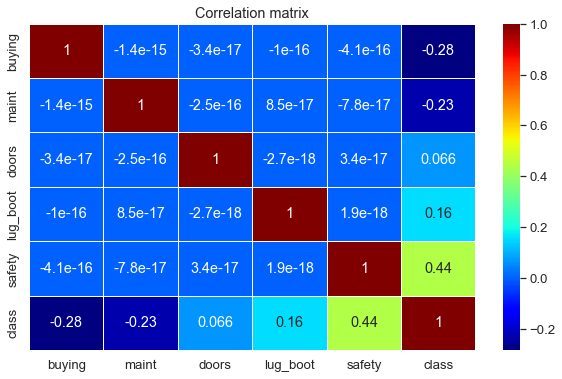

In [16]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
sns.heatmap(trans_data.corr(),annot=True, cmap='jet',linewidth=0.5)
plt.title('Correlation matrix');

`class` and `maint` are highly correlated (negatively) 
 
`buying` and `class` are highly correlated (negatively) 

#### Testing the initial assumption

##### Let's look at the correlation matrix again:

In [17]:
corr_matrix = trans_data.corr()
corr_matrix['buying'].sort_values(ascending=False)

buying      1.000000e+00
doors      -3.433468e-17
lug_boot   -1.045866e-16
safety     -4.082114e-16
maint      -1.356939e-15
class      -2.827504e-01
Name: buying, dtype: float64

Attributes are negatively correlated with the `buying` attribute

> This makes the initial assumptions regarding positive correlation between buying and {doors, lug_boot, safety, persons } FALSE.

##### Let's look into the distribution of ***buying*** categories on other attributes

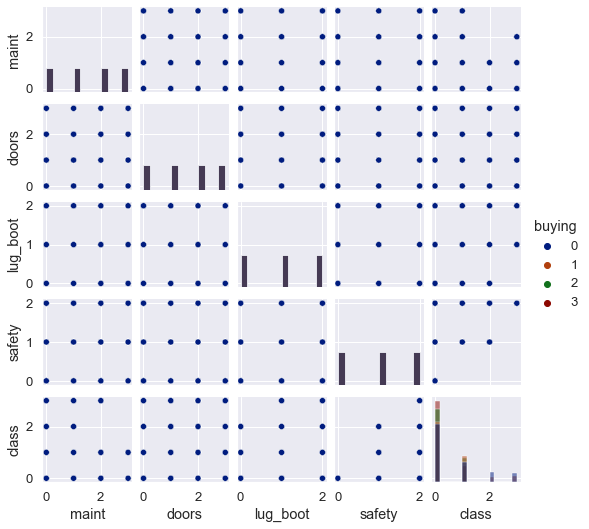

In [18]:
sns.pairplot(trans_data, hue="buying", diag_kind="hist", height=1.5, palette="dark")
plt.show()

#### Splitting the data into training and testing

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = trans_data.drop(['buying'], axis = 1)
y = trans_data['buying']

Following general convention - 80% training and 20% testing data, with random shuffling to prevent any potential selection bias

In [24]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# train_set['class'].value_counts()/len(train_set)
# test_set['class'].value_counts()/len(train_set)

## 4. Training, evaluating and error analysis on the training set <a id="cell4"></a>

In [25]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import tree

# ensemble models
from sklearn.ensemble import RandomForestClassifier

# metrics
# from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV 
from sklearn.metrics import confusion_matrix, mean_squared_error, \
mean_absolute_error, classification_report, precision_score, recall_score, f1_score,\
matthews_corrcoef, cohen_kappa_score, roc_auc_score

In [26]:
# good to test on various metrics for the multi-classification task
def cal_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))     
    print('Recall: %.3f' % recall_score(y_test, y_pred, average='micro'))
    print('F1: %.3f' % f1_score(y_test, y_pred, average='micro'))
    print("matthews_corrcoef: %.3f" % matthews_corrcoef(y_test, y_pred))
    print("cohen_kappa_score: %.3f" % cohen_kappa_score(y_test, y_pred))
    print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, y_pred))
    print("Mean absolute error (MAE): %.3f" % mean_absolute_error(y_test, y_pred))

# confusion matrix for error analysis
def create_confusion_matrix(y_test, y_pred, model_type):
    # Plot confusion matrix.
    cm_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_matrix, annot=True, cbar=True, cmap='jet',linewidth=0.5,fmt="d")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix for {}'.format(model_type));

### 4.1. Logistic Regression <a id="cell41"></a>

In [27]:
# Initialize a Logistic Regression classifier.
logreg = LogisticRegression(solver='saga', multi_class='auto', random_state=42, n_jobs=-1)
logreg.fit(X_train, y_train)

# cross validation evaluation
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=20)

In [28]:
# CV Accuracy
print('CV Accuracy: %.3f' % logreg_cv.mean())

CV Accuracy: 0.328


#### Predictions and error analysis

              precision    recall  f1-score   support

           0       0.36      0.43      0.39        83
           1       0.21      0.19      0.20        77
           2       0.26      0.13      0.17        92
           3       0.37      0.50      0.42        94

    accuracy                           0.32       346
   macro avg       0.30      0.31      0.30       346
weighted avg       0.30      0.32      0.30       346

Recall: 0.318
F1: 0.318
matthews_corrcoef: 0.091
cohen_kappa_score: 0.089
Mean squared error (MSE): 1.997
Mean absolute error (MAE): 1.049




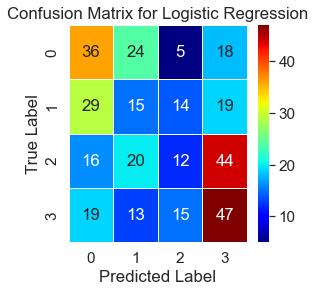

In [29]:
logreg_pred = logreg.predict(X_test)
cal_metrics(y_test, logreg_pred)
print('\n')
create_confusion_matrix(y_test, logreg_pred, "Logistic Regression")

### 4.2. Logistic Regression - Grid Search <a id="cell42"></a>

In [192]:
# Hyperparameters to be checked.
parameters = {'C':[0.0001,0.001, 0.01, 1, 0.1, 10, 100, 1000],
              'penalty':['none','l2'],
              'solver':['lbfgs','sag','saga','newton-cg']
             }

# Logistic Regression classifier.
default_logreg=LogisticRegression(multi_class='auto', random_state=42, n_jobs=-1)

# GridSearchCV estimator.
gs_logreg = GridSearchCV(default_logreg, parameters, cv=10, verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_logreg.fit(X_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000],
                         'penalty': ['none', 'l2'],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']},
             verbose=1)

In [200]:
# Best parameters.
print("Best Logistic Regression Parameters: {}".format(gs_logreg.best_params_))

# Cross validation accuracy for the best parameters.
print('CV accuracy: %0.3f' % gs_logreg.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_logreg.score(X_test, y_test)))

Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV accuracy: 0.329
Accuracy: 0.327


### 4.3. K-Nearest Neighbours  <a id="cell43"></a>

In [60]:
# Initialize a decision tree estimator.
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=300)
# Train the estimator.
knn.fit(X_train, y_train)

# cross validation evaluation
knn_cv = cross_val_score(knn, X_train, y_train, cv=20)

In [62]:
# CV Accuracy
print('CV Accuracy: %.3f' % knn_cv.mean())

CV Accuracy: 0.313


#### Predictions and error analysis

              precision    recall  f1-score   support

           0       0.39      0.24      0.30        83
           1       0.18      0.25      0.21        77
           2       0.32      0.32      0.32        92
           3       0.35      0.37      0.36        94

    accuracy                           0.30       346
   macro avg       0.31      0.29      0.30       346
weighted avg       0.31      0.30      0.30       346

Recall: 0.298
F1: 0.298
matthews_corrcoef: 0.063
cohen_kappa_score: 0.063
Mean squared error (MSE): 1.844
Mean absolute error (MAE): 1.029




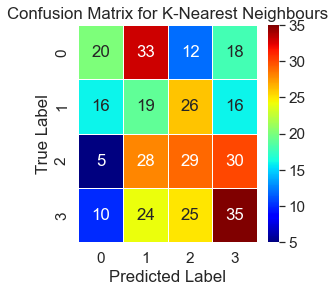

In [64]:
knn_pred = knn.predict(X_test)
cal_metrics(y_test, knn_pred)
print('\n')
create_confusion_matrix(y_test, knn_pred, "K-Nearest Neighbours")

### 4.4. Decision Trees <a id="cell44"></a>

In [85]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=42)
# Train the estimator.
tr.fit(X_train, y_train)

# cross validation evaluation
tr_cv = cross_val_score(tr, X_train, y_train, cv=20)

In [86]:
# CV Accuracy
print('CV Accuracy: %.3f' % tr_cv.mean())

CV Accuracy: 0.311


#### Predictions and error analysis

              precision    recall  f1-score   support

           0       0.25      0.58      0.35        83
           1       0.22      0.26      0.24        77
           2       0.20      0.04      0.07        92
           3       0.57      0.26      0.35        94

    accuracy                           0.28       346
   macro avg       0.31      0.28      0.25       346
weighted avg       0.32      0.28      0.25       346

Recall: 0.277
F1: 0.277
matthews_corrcoef: 0.055
cohen_kappa_score: 0.048
Mean squared error (MSE): 2.410
Mean absolute error (MAE): 1.191




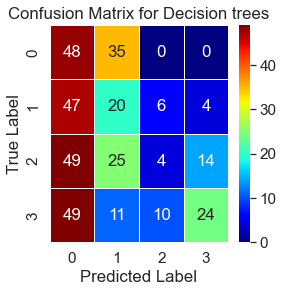

In [88]:
tr_pred = tr.predict(X_test)
cal_metrics(y_test, tr_pred)
print('\n')
create_confusion_matrix(y_test, tr_pred, "Decision trees")

### 4.5. Decision Trees - Grid Search <a id="cell45"></a>

In [195]:
# Hyperparameters to be checked.
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
             }

# Default Decision tree estimator.
default_tr = tree.DecisionTreeClassifier(random_state=42)

# GridSearchCV estimator.
gs_tree = GridSearchCV(default_tr, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_tree.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

In [199]:
# Best parameters.
print("Best Decision Tree Parameters: {}".format(gs_tree.best_params_))

# Cross validation accuracy for the best parameters.
print('CV accuracy: %0.3f' % gs_tree.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_tree.score(X_test, y_test)))

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3}
CV accuracy: 0.321
Accuracy: 0.298


### 4.6. Multi Layered Perceptron <a id="cell46"></a>

In [93]:
mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=100, random_state=42, shuffle=True, verbose=False)
mlp.fit(X_train, y_train)

# cross validation evaluation
mlp_cv = cross_val_score(mlp, X_train, y_train, cv=20)

In [94]:
# CV Accuracy
print('CV Accuracy: %.3f' % mlp_cv.mean())

CV Accuracy: 0.321


#### Predictions and error analysis

              precision    recall  f1-score   support

           0       0.50      0.41      0.45        83
           1       0.23      0.30      0.26        77
           2       0.25      0.16      0.20        92
           3       0.36      0.45      0.40        94

    accuracy                           0.33       346
   macro avg       0.33      0.33      0.33       346
weighted avg       0.33      0.33      0.33       346

Recall: 0.329
F1: 0.329
matthews_corrcoef: 0.107
cohen_kappa_score: 0.106
Mean squared error (MSE): 1.624
Mean absolute error (MAE): 0.954




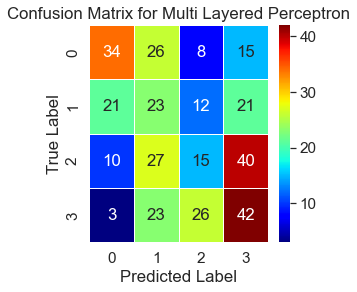

In [96]:
mlp_pred = mlp.predict(X_test)
cal_metrics(y_test, mlp_pred)
print('\n')
create_confusion_matrix(y_test, mlp_pred, "Multi Layered Perceptron")

### 4.7. Multi Layered Perceptron - Grid Search <a id="cell47"></a>

In [ ]:
# Hyperparameters to be checked.
parameters = {'activation':['logistic','tanh','relu'],
              'solver': ['lbfgs','adam','sgd'],
              'alpha':10.0 ** -np.arange(1,3),
              'hidden_layer_sizes':[(5),(100),(3),(4),(3,1),(5,3)]}

# MLP estimator.
default_mlp = MLPClassifier(random_state=42)

# GridSearchCV estimator.
gs_mlp = GridSearchCV(default_mlp, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_mlp.fit(X_train,y_train)

              precision    recall  f1-score   support

           0       0.59      0.35      0.44        83
           1       0.20      0.27      0.23        77
           2       0.37      0.24      0.29        92
           3       0.41      0.59      0.48        94

    accuracy                           0.37       346
   macro avg       0.39      0.36      0.36       346
weighted avg       0.40      0.37      0.37       346

Recall: 0.367
F1: 0.367
matthews_corrcoef: 0.158
cohen_kappa_score: 0.154
Mean squared error (MSE): 1.569
Mean absolute error (MAE): 0.910




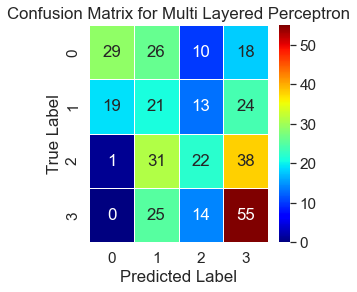

In [198]:
gs_mlp_pred = gs_mlp.predict(X_test)
cal_metrics(y_test, gs_mlp_pred)
print('\n')
create_confusion_matrix(y_test, gs_mlp_pred, "Multi Layered Perceptron")

In [190]:
# Best parameters.
print("Best MLP Parameters: {}".format(gs_mlp.best_params_))

# Cross validation accuracy for the best parameters.
print('CV accuracy: %0.3f' % gs_mlp.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_mlp.score(X_test,y_test)))

Best MLP Parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (3, 1), 'solver': 'lbfgs'}
CV accuracy: 0.353
Accuracy: 0.367


### 4.8. Ensembling - Random Forest <a id="cell48"></a>

In [182]:
# Initialize a Random Forest classifier.
rfc = RandomForestClassifier(n_jobs=-1, 
                             min_samples_leaf=2,
                             max_depth=4,
                             n_estimators=10, 
                             min_samples_split=5, 
                             random_state=51)
rfc.fit(X_train, y_train)

# cross validation evaluation
rfc_cv = cross_val_score(rfc, X_train, y_train, cv=20)

In [183]:
# CV Accuracy
print('CV Accuracy: %.3f' % rfc_cv.mean())

CV Accuracy: 0.319


#### Predictions and error analysis

              precision    recall  f1-score   support

           0       0.45      0.27      0.33        83
           1       0.26      0.22      0.24        77
           2       0.29      0.23      0.25        92
           3       0.30      0.51      0.38        94

    accuracy                           0.31       346
   macro avg       0.32      0.31      0.30       346
weighted avg       0.32      0.31      0.30       346

Recall: 0.312
F1: 0.312
matthews_corrcoef: 0.077
cohen_kappa_score: 0.075
Mean squared error (MSE): 1.974
Mean absolute error (MAE): 1.043




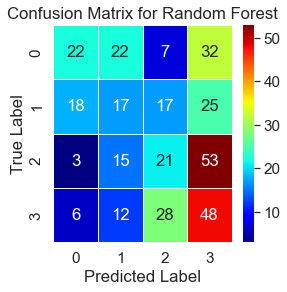

In [184]:
rfc_pred = rfc.predict(X_test)
cal_metrics(y_test, rfc_pred)
print('\n')
create_confusion_matrix(y_test, rfc_pred, "Random Forest")

## 5. Selecting the best model <a id="cell5"></a>

**Neural network (Multi Layered perceptron) with Grid Search** performed the best among other machine learning models tested. 
```
With parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (3, 1), 'solver': 'lbfgs'}
CV accuracy: 0.353
Accuracy: 0.367
```

## 6. Conclusions: Presenting solutions <a id="cell6"></a>

With data analysis and modelling I have following conclusions:

1. The best model with `36.7%` performs far worse than the random chance (50% accuracy). Such models are NOT suitable for a business use case. Rather a data-driven approach needs to be applied rather than focusing on a model-driven approach i.e. finding the best model. 

2. Clearly, with `36.7%` accuracy the model didn't converge to an optimal loss. 

3. Error analysis with confusion matrix refects random guessing across the `buying price` categories.

4. The data failed my assumptions of the correlations. While my assumptions might be flawed but I believe that help from an expert in the required field can help curate the data. 

5. The data already has fewer features and even if I dropped the least important feature or correlated ones, then also the accuracy was reduced by around `1-2%`. So, dropping a feature is not an option to reduce variance in a model.

6. Collecting other features (attributes) and scaling data can be helpful. 